In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

def process_metrics(csv_path: str, name: str):
    """
    Reads a CSV file, computes classification metrics, and returns the results.
    Also generates an AUC-ROC visualization with error bars using bootstrapping.
    
    Parameters:
    csv_path (str): Path to the CSV file.
    name (str): Name identifier for the dataset.
    
    Returns:
    dict: A dictionary containing accuracy, precision, recall, F1-score, and AUC with confidence intervals.
    """
    df        = pd.read_csv(csv_path)
    
    y_true    = df['True_Label'].astype(int)
    y_pred    = df['Predicted_Label'].astype(int)
    y_score   = df['Prediction_Probability']
    
    accuracy  = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)
    
    np.random.seed(42)
    n_bootstraps     = 100
    auc_scores       = []
    accuracy_scores  = []
    precision_scores = []
    recall_scores    = []
    f1_scores        = []

    fpr_list         = []
    tpr_list         = []
    
    for _ in range(n_bootstraps):
        indices      = np.random.choice(len(y_true), size=len(y_true), replace=True)
        y_true_boot  = y_true.iloc[indices]
        y_pred_boot  = y_pred.iloc[indices]
        y_score_boot = y_score.iloc[indices]
        
        auc_scores.append(roc_auc_score(y_true_boot, y_score_boot))
        accuracy_scores.append(accuracy_score(y_true_boot, y_pred_boot))
        precision_scores.append(precision_score(y_true_boot, y_pred_boot, zero_division=0))
        recall_scores.append(recall_score(y_true_boot, y_pred_boot, zero_division=0))
        f1_scores.append(f1_score(y_true_boot, y_pred_boot, zero_division=0))
        
        fpr, tpr, _ = roc_curve(y_true_boot, y_score_boot)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
    
    mean_auc     = np.mean(auc_scores)
    ci_auc       = (np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5))
    ci_accuracy  = (np.percentile(accuracy_scores, 2.5), np.percentile(accuracy_scores, 97.5))
    ci_precision = (np.percentile(precision_scores, 2.5), np.percentile(precision_scores, 97.5))
    ci_recall    = (np.percentile(recall_scores, 2.5), np.percentile(recall_scores, 97.5))
    ci_f1        = (np.percentile(f1_scores, 2.5), np.percentile(f1_scores, 97.5))
    
    plt.figure(figsize=(8, 5))
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list)], axis=0)
    std_tpr  = np.std([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(fpr_list, tpr_list)], axis=0)
    
    plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean AUC: {mean_auc:.3f} (95% CI: {ci_auc[0]:.3f}-{ci_auc[1]:.3f})')
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='blue', alpha=0.2, label='95% CI')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random (AUC = 0.50)')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'AUC-ROC Curve for {name}')
    plt.legend()
    plt.show()
    
    return {
        'name': name,
        'accuracy': (accuracy, ci_accuracy),
        'precision': (precision, ci_precision),
        'recall': (recall, ci_recall),
        'f1_score': (f1, ci_f1),
        'auc_mean': mean_auc,
        'auc_ci': ci_auc
    }


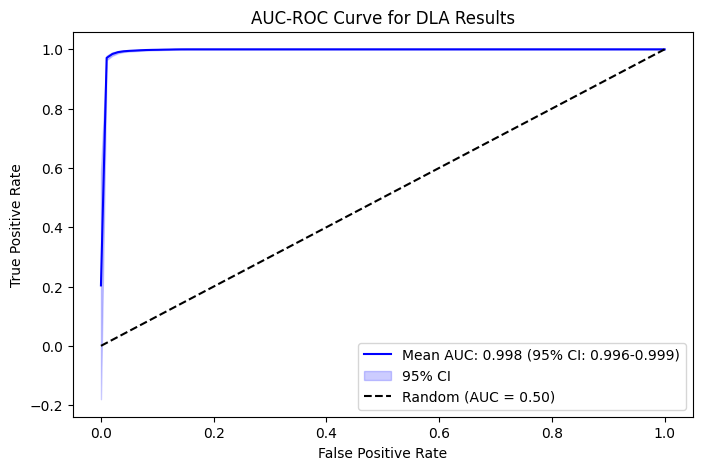

{'name': 'DLA Results',
 'accuracy': (0.9705042816365367,
  (np.float64(0.9635941960038059), np.float64(0.9778901046622265))),
 'precision': (0.9513014273719563,
  (np.float64(0.9398567851925891), np.float64(0.9640477071576156))),
 'recall': (0.9964819700967458,
  (np.float64(0.9925176093180575), np.float64(0.9991312273550724))),
 'f1_score': (0.9733676975945017,
  (np.float64(0.9669219182557626), np.float64(0.9802229227537308))),
 'auc_mean': np.float64(0.9978207705500699),
 'auc_ci': (np.float64(0.9962118145091774), np.float64(0.999285434183259))}

In [13]:
process_metrics("./results/dla_results.csv", "DLA Results")

Accuracy: 0.9696
Precision: 0.9482
Recall: 0.9982
F1 Score: 0.9726

Bootstrapped AUC (mean): 0.9983
95% Confidence Interval: (0.9973, 0.9991)

Accuracy: 0.9705
Precision: 0.9513
Recall: 0.9965
F1 Score: 0.9734

Bootstrapped AUC (mean): 0.9978
95% Confidence Interval: (0.9962, 0.9993)